In [18]:
## This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [19]:
from transformers import BertTokenizer, BertForQuestionAnswering
import torch
torch.device('cuda')
# Load pre-trained model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForQuestionAnswering.from_pretrained(model_name)
model = model.to('cuda')

# Example question and context


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
def heading(context1):
    question = "What is title for this text?"
    context = context1

    # Tokenize input
    inputs = tokenizer(question, context, return_tensors='pt')
    inputs.to('cuda')
    # Perform inference
    outputs = model(**inputs)
    start_scores = outputs.start_logits
    end_scores = outputs.end_logits

    # Get the answer
    start_index = torch.argmax(start_scores)
    end_index = torch.argmax(end_scores) + 1  # Add 1 because end_index is inclusive
    answer_tokens = inputs['input_ids'][0][start_index:end_index]
    answer = tokenizer.decode(answer_tokens)

    return answer


In [21]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Load pretrained BART model and tokenizer
model_name = 'facebook/bart-large-cnn'
tokenizer1 = BartTokenizer.from_pretrained(model_name)
model1 = BartForConditionalGeneration.from_pretrained(model_name)
model1.to('cuda')

BartForConditionalGeneration(
  (model): BartModel(
    (shared): Embedding(50264, 1024, padding_idx=1)
    (encoder): BartEncoder(
      (embed_tokens): BartScaledWordEmbedding(50264, 1024, padding_idx=1)
      (embed_positions): BartLearnedPositionalEmbedding(1026, 1024)
      (layers): ModuleList(
        (0-11): 12 x BartEncoderLayer(
          (self_attn): BartSdpaAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=4096, out_features=1024, bias=True)
          (final_l

In [22]:
def generate_short_heading(paragraph):
    # Tokenize input paragraph
    inputs = tokenizer1([paragraph], max_length=1024, return_tensors='pt', truncation=True)
    inputs.to('cuda')
    # Generate heading using BART model
    summary_ids = model1.generate(inputs['input_ids'], num_beams=4, max_length=5, early_stopping=True)
    heading = tokenizer1.decode(summary_ids[0], skip_special_tokens=True)

    return heading

In [23]:
def bullet_pts(text1):
    text = text1

    # Tokenize the input text
    inputs = tokenizer1([text], max_length=1024, return_tensors='pt', truncation=True)
    inputs.to('cuda')
    # Generate summary
    summary_ids = model1.generate(inputs['input_ids'], num_beams=4, min_length=30, max_length=100, early_stopping=True)

    # Decode and print the summarized text
    summary = tokenizer1.decode(summary_ids[0], skip_special_tokens=True)
    bullet_points = summary.split('. ')  # Split into bullet points based on periods
    return bullet_points

In [24]:

text='Deep in the dense forest, ancient trees stood sentinel over a carpet of moss and ferns. Shafts of sunlight pierced the canopy above, dappling the forest floor with patches of golden warmth. The air was thick with the earthy scent of moss and decay, punctuated by the occasional call of a hidden bird or the rustle of small creatures foraging in the underbrush.'
print(generate_short_heading(text))

Deep in


/home/arunav/.conda/envs/tf-gpu/lib/python3.11/site-packages/transformers/generation/utils.py:1273: UserWarning: Unfeasible length constraints: `min_length` (56) is larger than the maximum possible length (5). Generation will stop at the defined maximum length. You should decrease the minimum length and/or increase the maximum length.
  warnings.warn(


['weaving through the gentle rustling of leaves in the evening breeze. a lone figure walked along the winding path, lost in thought, their footsteps echoing faintly in the stillness of the approaching twilight', '', 'punctuated by the occasional call of a hidden bird or the rustle of small creatures foraging in the underbrush']


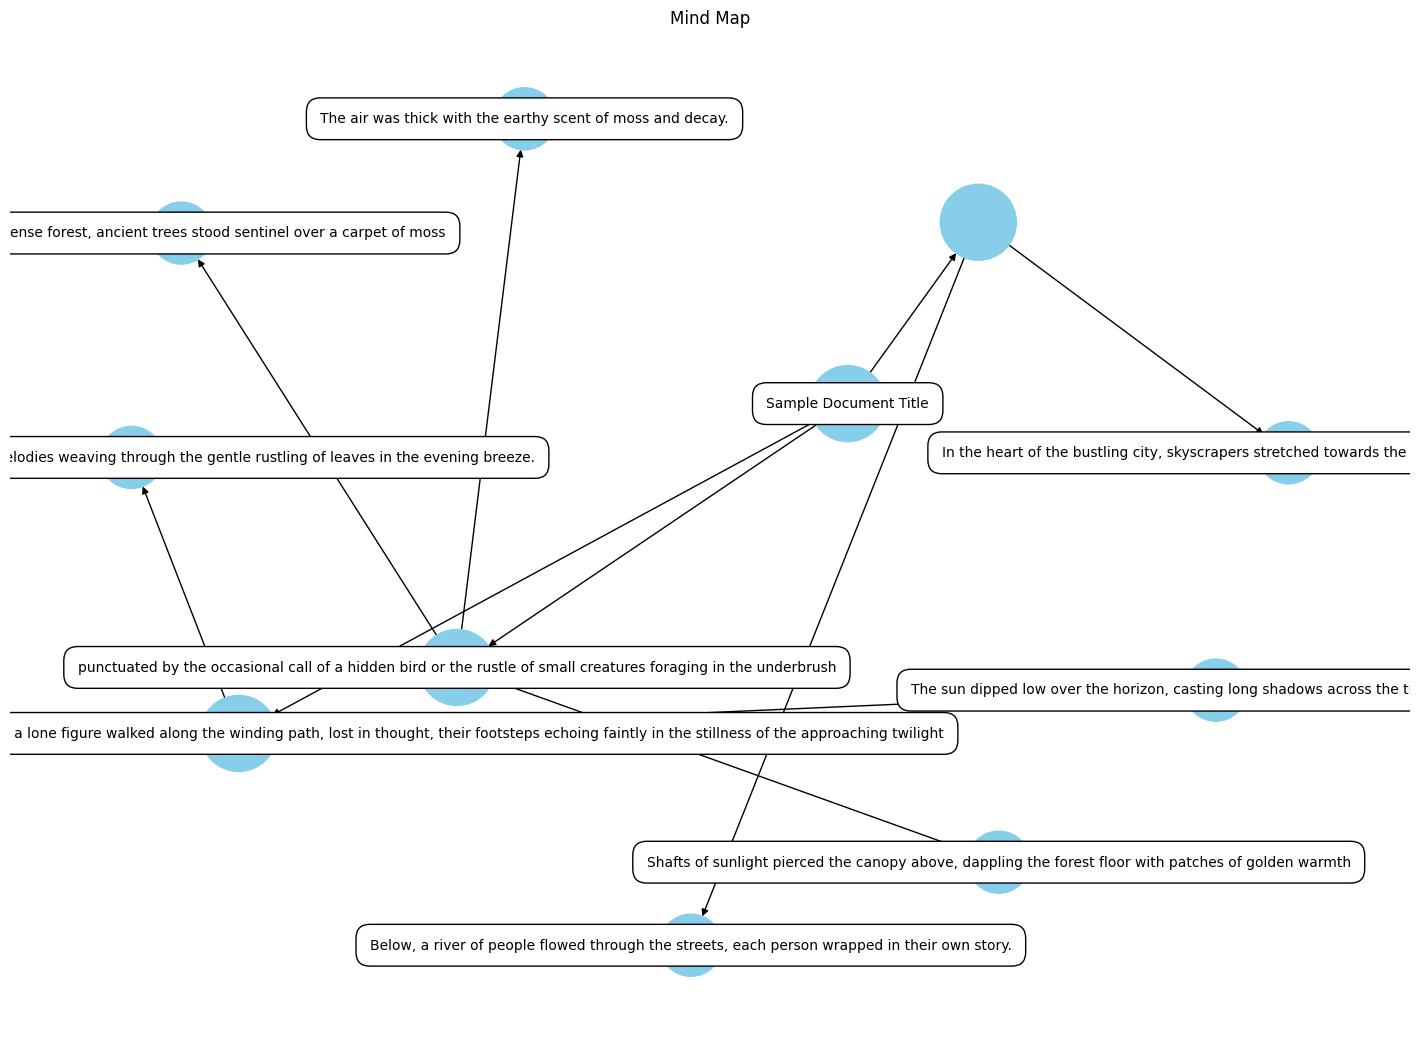

In [34]:
import matplotlib.pyplot as plt
import networkx as nx
from transformers import pipeline

# Initialize BERT and BART pipelines
# bert_pipeline = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
# bart_pipeline = pipeline("summarization", model="facebook/bart-large-cnn")

# Dummy document and paragraphs
document_title = "Sample Document Title"
paragraphs = [
    "The sun dipped low over the horizon, casting long shadows across the tranquil meadow. Birds chirped softly in the trees, their melodies weaving through the gentle rustling of leaves in the evening breeze. A lone figure walked along the winding path, lost in thought, their footsteps echoing faintly in the stillness of the approaching twilight.",
    "In the heart of the bustling city, skyscrapers stretched towards the sky like giants of glass and steel. Below, a river of people flowed through the streets, each person wrapped in their own story, a tapestry of dreams and ambitions. Neon lights flickered, painting the sidewalks with a kaleidoscope of colors, as cars hummed past, tracing lines of light along the asphalt.",
    "Deep in the dense forest, ancient trees stood sentinel over a carpet of moss and ferns. Shafts of sunlight pierced the canopy above, dappling the forest floor with patches of golden warmth. The air was thick with the earthy scent of moss and decay, punctuated by the occasional call of a hidden bird or the rustle of small creatures foraging in the underbrush."
]


# Extract titles and summaries
titles = [heading(p) for p in paragraphs]
summaries = [bullet_pts(p) for p in paragraphs]

# Create a mind map using matplotlib and networkx
G = nx.DiGraph()

# Add document title as central node
G.add_node(document_title, size=3000)
print(titles)

# Add paragraph titles and summaries
for i, title in enumerate(titles):
    G.add_node(title, size=3000)
    G.add_edge(document_title, title)
    
    bullet_points = summaries[i]
    for bullet in bullet_points:
        if bullet:
            G.add_node(bullet, size=2000)
            G.add_edge(title, bullet)

# Adjust the layout to prevent overlap
pos = nx.spring_layout(G, k=2, iterations=50)

# Draw the mind map
plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=True, node_size=[G.nodes[n]['size'] for n in G.nodes], font_size=10, node_color='skyblue', font_color='black', bbox=dict(facecolor="white", edgecolor='black', boxstyle='round,pad=1'))
plt.title("Mind Map")
plt.show()
